**김동현이 4시간동안 쌈뽕하게 노력한 실험실**

1. CartPole-v1 : 200 이상 나오게 노력중
2. MountainCar-v0 : -110 이상 나오게 노력중
3. Acrobot-v1 : -100 이상 나오게 노력중

**결과값을 다 일일히 기록하느냐?**
**- 그것이 간지니깐**

In [ ]:
pip install torch gym numpy

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical, Normal
import numpy as np

# 환경 설정
environments = ['CartPole-v1', 'MountainCar-v0', 'Acrobot-v1']

# 정책 네트워크 정의
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, action_space_type):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, action_dim)
        self.action_space_type = action_space_type

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def get_action(self, state):
        logits = self.forward(state)
        if self.action_space_type == 'Discrete':
            action_dist = Categorical(logits=logits)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action)
        else:  # Box
            action_dist = Normal(logits, torch.ones_like(logits) * 0.1)  # 0.1은 표준 편차 값
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action).sum()
        return action, log_prob

# 메타학습 (MAML) 함수
def maml_update(env_name, state_dim, action_dim, action_space_type, meta_policy, meta_optimizer, inner_lr, train_episodes):
    env = gym.make(env_name)

    inner_policy = PolicyNetwork(state_dim, action_dim, action_space_type)
    inner_policy.load_state_dict(meta_policy.state_dict())
    inner_optimizer = optim.Adam(inner_policy.parameters(), lr=inner_lr)

    # Inner loop (적응 단계)
    for _ in range(train_episodes):
        result = env.reset()  # state와 info를 분리하여 처리
        state = result if isinstance(result, np.ndarray) else result[0]
        done = False
        while not done:
            state = torch.tensor(state, dtype=torch.float32)
            action, log_prob = inner_policy.get_action(state)
            next_state, reward, done, info = env.step(action.item() if action_space_type == 'Discrete' else action.detach().numpy())
            loss = -log_prob * reward
            inner_optimizer.zero_grad()
            loss.backward()
            inner_optimizer.step()
            state = next_state

    # Meta update (메타학습 단계)
    result = env.reset()  # state와 info를 분리하여 처리
    state = result if isinstance(result, np.ndarray) else result[0]
    done = False
    meta_loss = 0
    while not done:
        state = torch.tensor(state, dtype=torch.float32)
        action, log_prob = inner_policy.get_action(state)
        next_state, reward, done, info = env.step(action.item() if action_space_type == 'Discrete' else action.detach().numpy())
        loss = -log_prob * reward
        meta_loss += loss
        state = next_state

    meta_optimizer.zero_grad()
    meta_loss.backward()
    meta_optimizer.step()

# 강화학습 (PPO) 함수
def ppo_update(env_name, state_dim, action_dim, action_space_type, policy, optimizer, epochs, gamma=0.99, eps_clip=0.2):
    env = gym.make(env_name)

    for epoch in range(epochs):
        result = env.reset()  # state와 info를 분리하여 처리
        state = result if isinstance(result, np.ndarray) else result[0]
        done = False
        rewards, log_probs, states, actions = [], [], [], []

        while not done:
            state = torch.tensor(state, dtype=torch.float32)
            action, log_prob = policy.get_action(state)
            next_state, reward, done, info = env.step(action.item() if action_space_type == 'Discrete' else action.detach().numpy())

            rewards.append(reward)
            log_probs.append(log_prob)
            states.append(state)
            actions.append(action)

            state = next_state

        # GAE와 PPO 손실 계산
        returns = []
        discounted_sum = 0
        for reward in reversed(rewards):
            discounted_sum = reward + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        returns = torch.tensor(returns, dtype=torch.float32)
        log_probs = torch.stack(log_probs)

        advantages = returns  # 간단화를 위해 값 함수 생략
        new_log_probs = []
        for state, action in zip(states, actions):
            _, new_log_prob = policy.get_action(state)
            new_log_probs.append(new_log_prob)
        new_log_probs = torch.stack(new_log_probs)

        ratio = torch.exp(new_log_probs - log_probs)

        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantages
        loss = -torch.min(surr1, surr2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 메타학습 및 강화학습 수행
meta_lr = 0.001
inner_lr = 0.01
train_episodes = 2  # 에피소드 수 줄이기
test_episodes = 2  # 에피소드 수 줄이기
epochs = 1  # 에폭 수 줄이기

meta_policies = {}
meta_optimizers = {}

for env_name in environments:
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_space_type = 'Discrete' if isinstance(env.action_space, gym.spaces.Discrete) else 'Box'
    action_dim = env.action_space.n if action_space_type == 'Discrete' else env.action_space.shape[0]

    # 각 환경에 맞는 메타 정책 네트워크 생성
    meta_policy = PolicyNetwork(state_dim, action_dim, action_space_type)
    meta_optimizer = optim.Adam(meta_policy.parameters(), lr=meta_lr)

    meta_policies[env_name] = meta_policy
    meta_optimizers[env_name] = meta_optimizer

for iteration in range(10):  # 반복 수 줄이기
    for env_name in environments:
        print(f"Iteration {iteration+1}/10")
        print(f"Updating environment: {env_name}")

        state_dim = meta_policies[env_name].fc1.in_features
        action_dim = meta_policies[env_name].fc2.out_features
        action_space_type = meta_policies[env_name].action_space_type

        maml_update(env_name, state_dim, action_dim, action_space_type, meta_policies[env_name], meta_optimizers[env_name], inner_lr, train_episodes)
        ppo_update(env_name, state_dim, action_dim, action_space_type, meta_policies[env_name], meta_optimizers[env_name], epochs)
        print(f"Finished updating environment: {env_name}")


Iteration 1/10
Updating environment: CartPole-v1
Finished updating environment: CartPole-v1
Iteration 1/10
Updating environment: MountainCar-v0
Finished updating environment: MountainCar-v0
Iteration 1/10
Updating environment: Acrobot-v1
Finished updating environment: Acrobot-v1
Iteration 2/10
Updating environment: CartPole-v1
Finished updating environment: CartPole-v1
Iteration 2/10
Updating environment: MountainCar-v0
Finished updating environment: MountainCar-v0
Iteration 2/10
Updating environment: Acrobot-v1
Finished updating environment: Acrobot-v1
Iteration 3/10
Updating environment: CartPole-v1
Finished updating environment: CartPole-v1
Iteration 3/10
Updating environment: MountainCar-v0
Finished updating environment: MountainCar-v0
Iteration 3/10
Updating environment: Acrobot-v1
Finished updating environment: Acrobot-v1
Iteration 4/10
Updating environment: CartPole-v1
Finished updating environment: CartPole-v1
Iteration 4/10
Updating environment: MountainCar-v0
Finished updatin

Environment: CartPole-v1, Average Reward: 18.0, Std: 10.353743284435827
Environment: MountainCar-v0, Average Reward: -200.0, Std: 0.0
Environment: Acrobot-v1, Average Reward: -500.0, Std: 0.0


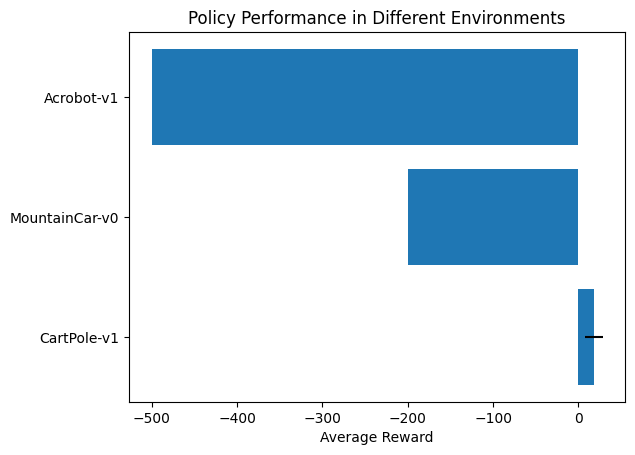

In [ ]:
import matplotlib.pyplot as plt

def evaluate_policy(env_name, policy, episodes=10):
    env = gym.make(env_name)
    total_rewards = []

    for episode in range(episodes):
        result = env.reset()
        state = result if isinstance(result, np.ndarray) else result[0]
        done = False
        total_reward = 0

        while not done:
            state = torch.tensor(state, dtype=torch.float32)
            action, _ = policy.get_action(state)
            next_state, reward, done, info = env.step(action.item() if isinstance(env.action_space, gym.spaces.Discrete) else action.detach().numpy())
            total_reward += reward
            state = next_state

        total_rewards.append(total_reward)

    env.close()
    avg_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)

    return avg_reward, std_reward

def plot_results(results):
    fig, ax = plt.subplots()
    envs = list(results.keys())
    avg_rewards = [results[env][0] for env in envs]
    std_rewards = [results[env][1] for env in envs]

    ax.barh(envs, avg_rewards, xerr=std_rewards, align='center')
    ax.set_xlabel('Average Reward')
    ax.set_title('Policy Performance in Different Environments')
    plt.show()

# 학습된 정책 평가
results = {}
for env_name in environments:
    avg_reward, std_reward = evaluate_policy(env_name, meta_policies[env_name])
    results[env_name] = (avg_reward, std_reward)
    print(f"Environment: {env_name}, Average Reward: {avg_reward}, Std: {std_reward}")

# 결과 시각화
plot_results(results)


Iteration 1/10
Updating environment: CartPole-v1
Finished updating environment: CartPole-v1
Iteration 1/10
Updating environment: MountainCar-v0
Finished updating environment: MountainCar-v0
Iteration 1/10
Updating environment: Acrobot-v1
Finished updating environment: Acrobot-v1
Iteration 2/10
Updating environment: CartPole-v1
Finished updating environment: CartPole-v1
Iteration 2/10
Updating environment: MountainCar-v0
Finished updating environment: MountainCar-v0
Iteration 2/10
Updating environment: Acrobot-v1
Finished updating environment: Acrobot-v1
Iteration 3/10
Updating environment: CartPole-v1
Finished updating environment: CartPole-v1
Iteration 3/10
Updating environment: MountainCar-v0
Finished updating environment: MountainCar-v0
Iteration 3/10
Updating environment: Acrobot-v1
Finished updating environment: Acrobot-v1
Iteration 4/10
Updating environment: CartPole-v1
Finished updating environment: CartPole-v1
Iteration 4/10
Updating environment: MountainCar-v0
Finished updatin

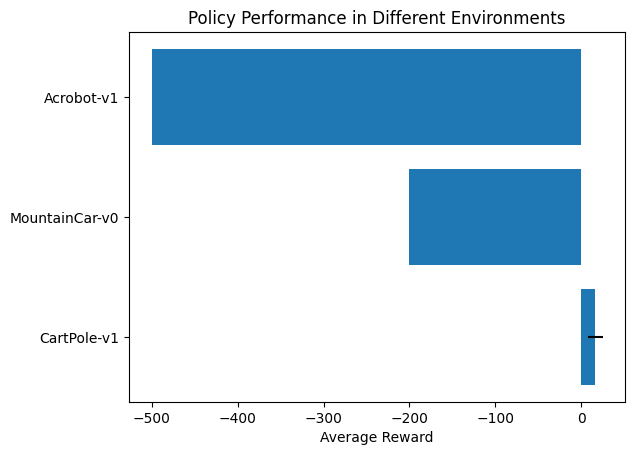

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical, Normal
import numpy as np
import matplotlib.pyplot as plt

# 환경 설정
environments = ['CartPole-v1', 'MountainCar-v0', 'Acrobot-v1']

# 정책 네트워크 정의
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, action_space_type):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)  # 128에서 256으로 확장
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, action_dim)
        self.action_space_type = action_space_type

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def get_action(self, state):
        logits = self.forward(state)
        if self.action_space_type == 'Discrete':
            action_dist = Categorical(logits=logits)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action)
        else:  # Box
            action_dist = Normal(logits, torch.ones_like(logits) * 0.1)  # 0.1은 표준 편차 값
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action).sum()
        return action, log_prob

# 메타학습 (MAML) 함수
def maml_update(env_name, state_dim, action_dim, action_space_type, meta_policy, meta_optimizer, inner_lr, train_episodes):
    env = gym.make(env_name)

    inner_policy = PolicyNetwork(state_dim, action_dim, action_space_type)
    inner_policy.load_state_dict(meta_policy.state_dict())
    inner_optimizer = optim.Adam(inner_policy.parameters(), lr=inner_lr)

    # Inner loop (적응 단계)
    for _ in range(train_episodes):
        result = env.reset()  # state와 info를 분리하여 처리
        state = result if isinstance(result, np.ndarray) else result[0]
        done = False
        while not done:
            state = torch.tensor(state, dtype=torch.float32)
            action, log_prob = inner_policy.get_action(state)
            next_state, reward, done, info = env.step(action.item() if action_space_type == 'Discrete' else action.detach().numpy())
            loss = -log_prob * reward
            inner_optimizer.zero_grad()
            loss.backward()
            inner_optimizer.step()
            state = next_state

    # Meta update (메타학습 단계)
    result = env.reset()  # state와 info를 분리하여 처리
    state = result if isinstance(result, np.ndarray) else result[0]
    done = False
    meta_loss = 0
    while not done:
        state = torch.tensor(state, dtype=torch.float32)
        action, log_prob = inner_policy.get_action(state)
        next_state, reward, done, info = env.step(action.item() if action_space_type == 'Discrete' else action.detach().numpy())
        loss = -log_prob * reward
        meta_loss += loss
        state = next_state

    meta_optimizer.zero_grad()
    meta_loss.backward()
    meta_optimizer.step()

# 강화학습 (PPO) 함수
def ppo_update(env_name, state_dim, action_dim, action_space_type, policy, optimizer, epochs, gamma=0.99, eps_clip=0.2):
    env = gym.make(env_name)

    for epoch in range(epochs):
        result = env.reset()  # state와 info를 분리하여 처리
        state = result if isinstance(result, np.ndarray) else result[0]
        done = False
        rewards, log_probs, states, actions = [], [], [], []

        while not done:
            state = torch.tensor(state, dtype=torch.float32)
            action, log_prob = policy.get_action(state)
            next_state, reward, done, info = env.step(action.item() if action_space_type == 'Discrete' else action.detach().numpy())

            rewards.append(reward)
            log_probs.append(log_prob)
            states.append(state)
            actions.append(action)

            state = next_state

        # GAE와 PPO 손실 계산
        returns = []
        discounted_sum = 0
        for reward in reversed(rewards):
            discounted_sum = reward + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        returns = torch.tensor(returns, dtype=torch.float32)
        log_probs = torch.stack(log_probs)

        advantages = returns  # 간단화를 위해 값 함수 생략
        new_log_probs = []
        for state, action in zip(states, actions):
            _, new_log_prob = policy.get_action(state)
            new_log_probs.append(new_log_prob)
        new_log_probs = torch.stack(new_log_probs)

        ratio = torch.exp(new_log_probs - log_probs)

        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantages
        loss = -torch.min(surr1, surr2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 메타학습 및 강화학습 수행
meta_lr = 0.001
inner_lr = 0.01
train_episodes = 5  # 에피소드 수 증가
test_episodes = 5  # 에피소드 수 증가
epochs = 3  # 에폭 수 증가

meta_policies = {}
meta_optimizers = {}

for env_name in environments:
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_space_type = 'Discrete' if isinstance(env.action_space, gym.spaces.Discrete) else 'Box'
    action_dim = env.action_space.n if action_space_type == 'Discrete' else env.action_space.shape[0]

    # 각 환경에 맞는 메타 정책 네트워크 생성
    meta_policy = PolicyNetwork(state_dim, action_dim, action_space_type)
    meta_optimizer = optim.Adam(meta_policy.parameters(), lr=meta_lr)

    meta_policies[env_name] = meta_policy
    meta_optimizers[env_name] = meta_optimizer

for iteration in range(10):
    for env_name in environments:
        print(f"Iteration {iteration+1}/10")
        print(f"Updating environment: {env_name}")

        state_dim = meta_policies[env_name].fc1.in_features
        action_dim = meta_policies[env_name].fc3.out_features
        action_space_type = meta_policies[env_name].action_space_type

        maml_update(env_name, state_dim, action_dim, action_space_type, meta_policies[env_name], meta_optimizers[env_name], inner_lr, train_episodes)
        ppo_update(env_name, state_dim, action_dim, action_space_type, meta_policies[env_name], meta_optimizers[env_name], epochs)
        print(f"Finished updating environment: {env_name}")

# 평가 함수 및 결과 시각화 함수
def evaluate_policy(env_name, policy, episodes=10):
    env = gym.make(env_name)
    total_rewards = []

    for episode in range(episodes):
        result = env.reset()
        state = result if isinstance(result, np.ndarray) else result[0]
        done = False
        total_reward = 0

        while not done:
            state = torch.tensor(state, dtype=torch.float32)
            action, _ = policy.get_action(state)
            next_state, reward, done, info = env.step(action.item() if isinstance(env.action_space, gym.spaces.Discrete) else action.detach().numpy())
            total_reward += reward
            state = next_state

        total_rewards.append(total_reward)

    env.close()
    avg_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)

    return avg_reward, std_reward

def plot_results(results):
    fig, ax = plt.subplots()
    envs = list(results.keys())
    avg_rewards = [results[env][0] for env in envs]
    std_rewards = [results[env][1] for env in envs]

    ax.barh(envs, avg_rewards, xerr=std_rewards, align='center')
    ax.set_xlabel('Average Reward')
    ax.set_title('Policy Performance in Different Environments')
    plt.show()

# 학습된 정책 평가
results = {}
for env_name in environments:
    avg_reward, std_reward = evaluate_policy(env_name, meta_policies[env_name])
    results[env_name] = (avg_reward, std_reward)
    print(f"Environment: {env_name}, Average Reward: {avg_reward}, Std: {std_reward}")

# 결과 시각화
plot_results(results)


Iteration 1/10
Updating environment: CartPole-v1
Finished updating environment: CartPole-v1
Iteration 1/10
Updating environment: MountainCar-v0
Finished updating environment: MountainCar-v0
Iteration 1/10
Updating environment: Acrobot-v1
Finished updating environment: Acrobot-v1
Iteration 2/10
Updating environment: CartPole-v1
Finished updating environment: CartPole-v1
Iteration 2/10
Updating environment: MountainCar-v0
Finished updating environment: MountainCar-v0
Iteration 2/10
Updating environment: Acrobot-v1
Finished updating environment: Acrobot-v1
Iteration 3/10
Updating environment: CartPole-v1
Finished updating environment: CartPole-v1
Iteration 3/10
Updating environment: MountainCar-v0
Finished updating environment: MountainCar-v0
Iteration 3/10
Updating environment: Acrobot-v1
Finished updating environment: Acrobot-v1
Iteration 4/10
Updating environment: CartPole-v1
Finished updating environment: CartPole-v1
Iteration 4/10
Updating environment: MountainCar-v0
Finished updatin

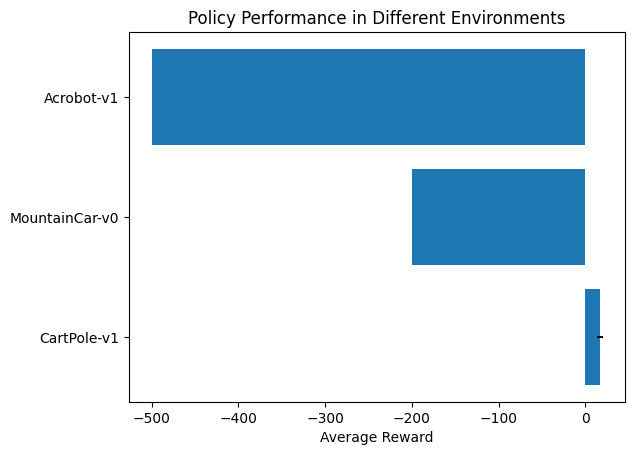

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical, Normal
import numpy as np
import matplotlib.pyplot as plt

# 환경 설정
environments = ['CartPole-v1', 'MountainCar-v0', 'Acrobot-v1']

# 정책 네트워크 정의
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, action_space_type):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)  # 128에서 256으로 확장
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, action_dim)
        self.action_space_type = action_space_type

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def get_action(self, state):
        logits = self.forward(state)
        if self.action_space_type == 'Discrete':
            action_dist = Categorical(logits=logits)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action)
        else:  # Box
            action_dist = Normal(logits, torch.ones_like(logits) * 0.1)  # 0.1은 표준 편차 값
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action).sum()
        return action, log_prob

# 메타학습 (MAML) 함수
def maml_update(env_name, state_dim, action_dim, action_space_type, meta_policy, meta_optimizer, inner_lr, train_episodes):
    env = gym.make(env_name)

    inner_policy = PolicyNetwork(state_dim, action_dim, action_space_type)
    inner_policy.load_state_dict(meta_policy.state_dict())
    inner_optimizer = optim.Adam(inner_policy.parameters(), lr=inner_lr)

    # Inner loop (적응 단계)
    for _ in range(train_episodes):
        result = env.reset()  # state와 info를 분리하여 처리
        state = result if isinstance(result, np.ndarray) else result[0]
        done = False
        while not done:
            state = torch.tensor(state, dtype=torch.float32)
            action, log_prob = inner_policy.get_action(state)
            next_state, reward, done, info = env.step(action.item() if action_space_type == 'Discrete' else action.detach().numpy())
            loss = -log_prob * reward
            inner_optimizer.zero_grad()
            loss.backward()
            inner_optimizer.step()
            state = next_state

    # Meta update (메타학습 단계)
    result = env.reset()  # state와 info를 분리하여 처리
    state = result if isinstance(result, np.ndarray) else result[0]
    done = False
    meta_loss = 0
    while not done:
        state = torch.tensor(state, dtype=torch.float32)
        action, log_prob = inner_policy.get_action(state)
        next_state, reward, done, info = env.step(action.item() if action_space_type == 'Discrete' else action.detach().numpy())
        loss = -log_prob * reward
        meta_loss += loss
        state = next_state

    meta_optimizer.zero_grad()
    meta_loss.backward()
    meta_optimizer.step()

# 강화학습 (PPO) 함수
def ppo_update(env_name, state_dim, action_dim, action_space_type, policy, optimizer, epochs, gamma=0.99, eps_clip=0.2):
    env = gym.make(env_name)

    for epoch in range(epochs):
        result = env.reset()  # state와 info를 분리하여 처리
        state = result if isinstance(result, np.ndarray) else result[0]
        done = False
        rewards, log_probs, states, actions = [], [], [], []

        while not done:
            state = torch.tensor(state, dtype=torch.float32)
            action, log_prob = policy.get_action(state)
            next_state, reward, done, info = env.step(action.item() if action_space_type == 'Discrete' else action.detach().numpy())

            rewards.append(reward)
            log_probs.append(log_prob)
            states.append(state)
            actions.append(action)

            state = next_state

        # GAE와 PPO 손실 계산
        returns = []
        discounted_sum = 0
        for reward in reversed(rewards):
            discounted_sum = reward + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        returns = torch.tensor(returns, dtype=torch.float32)
        log_probs = torch.stack(log_probs)

        advantages = returns  # 간단화를 위해 값 함수 생략
        new_log_probs = []
        for state, action in zip(states, actions):
            _, new_log_prob = policy.get_action(state)
            new_log_probs.append(new_log_prob)
        new_log_probs = torch.stack(new_log_probs)

        ratio = torch.exp(new_log_probs - log_probs)

        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantages
        loss = -torch.min(surr1, surr2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 메타학습 및 강화학습 수행
meta_lr = 0.001
inner_lr = 0.01
train_episodes = 10  # 에피소드 수 증가
test_episodes = 10  # 에피소드 수 증가
epochs = 5  # 에폭 수 증가

meta_policies = {}
meta_optimizers = {}

for env_name in environments:
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_space_type = 'Discrete' if isinstance(env.action_space, gym.spaces.Discrete) else 'Box'
    action_dim = env.action_space.n if action_space_type == 'Discrete' else env.action_space.shape[0]

    # 각 환경에 맞는 메타 정책 네트워크 생성
    meta_policy = PolicyNetwork(state_dim, action_dim, action_space_type)
    meta_optimizer = optim.Adam(meta_policy.parameters(), lr=meta_lr)

    meta_policies[env_name] = meta_policy
    meta_optimizers[env_name] = meta_optimizer

for iteration in range(10):
    for env_name in environments:
        print(f"Iteration {iteration+1}/10")
        print(f"Updating environment: {env_name}")

        state_dim = meta_policies[env_name].fc1.in_features
        action_dim = meta_policies[env_name].fc3.out_features
        action_space_type = meta_policies[env_name].action_space_type

        maml_update(env_name, state_dim, action_dim, action_space_type, meta_policies[env_name], meta_optimizers[env_name], inner_lr, train_episodes)
        ppo_update(env_name, state_dim, action_dim, action_space_type, meta_policies[env_name], meta_optimizers[env_name], epochs)
        print(f"Finished updating environment: {env_name}")

# 평가 함수 및 결과 시각화 함수
def evaluate_policy(env_name, policy, episodes=10):
    env = gym.make(env_name)
    total_rewards = []

    for episode in range(episodes):
        result = env.reset()
        state = result if isinstance(result, np.ndarray) else result[0]
        done = False
        total_reward = 0

        while not done:
            state = torch.tensor(state, dtype=torch.float32)
            action, _ = policy.get_action(state)
            next_state, reward, done, info = env.step(action.item() if isinstance(env.action_space, gym.spaces.Discrete) else action.detach().numpy())
            total_reward += reward
            state = next_state

        total_rewards.append(total_reward)

    env.close()
    avg_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)

    return avg_reward, std_reward

def plot_results(results):
    fig, ax = plt.subplots()
    envs = list(results.keys())
    avg_rewards = [results[env][0] for env in envs]
    std_rewards = [results[env][1] for env in envs]

    ax.barh(envs, avg_rewards, xerr=std_rewards, align='center')
    ax.set_xlabel('Average Reward')
    ax.set_title('Policy Performance in Different Environments')
    plt.show()

# 학습된 정책 평가
results = {}
for env_name in environments:
    avg_reward, std_reward = evaluate_policy(env_name, meta_policies[env_name])
    results[env_name] = (avg_reward, std_reward)
    print(f"Environment: {env_name}, Average Reward: {avg_reward}, Std: {std_reward}")

# 결과 시각화
plot_results(results)


In [39]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical, Normal
import numpy as np
import matplotlib.pyplot as plt

# 환경 설정
environments = ['CartPole-v1', 'MountainCar-v0', 'Acrobot-v1']

# 정책 네트워크 정의
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, action_space_type):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, action_dim)
        self.action_space_type = action_space_type

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def get_action(self, state):
        logits = self.forward(state)
        if self.action_space_type == 'Discrete':
            action_dist = Categorical(logits=logits)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action)
        else:
            action_dist = Normal(logits, torch.ones_like(logits) * 0.1)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action).sum()
        return action, log_prob

# 메타학습 (MAML) 함수
def maml_update(env_name, state_dim, action_dim, action_space_type, meta_policy, meta_optimizer, inner_lr, train_episodes):
    env = gym.make(env_name)

    inner_policy = PolicyNetwork(state_dim, action_dim, action_space_type)
    inner_policy.load_state_dict(meta_policy.state_dict())
    inner_optimizer = optim.Adam(inner_policy.parameters(), lr=inner_lr)

    # Inner loop (적응 단계)
    for _ in range(train_episodes):
        result = env.reset()
        state = result if isinstance(result, np.ndarray) else result[0]
        done = False
        while not done:
            state = torch.tensor(state, dtype=torch.float32)
            action, log_prob = inner_policy.get_action(state)
            next_state, reward, done, info = env.step(action.item() if action_space_type == 'Discrete' else action.detach().numpy())
            loss = -log_prob * reward
            inner_optimizer.zero_grad()
            loss.backward()
            inner_optimizer.step()
            state = next_state

    # Meta update (메타학습 단계)
    result = env.reset()
    state = result if isinstance(result, np.ndarray) else result[0]
    done = False
    meta_loss = 0
    while not done:
        state = torch.tensor(state, dtype=torch.float32)
        action, log_prob = inner_policy.get_action(state)
        next_state, reward, done, info = env.step(action.item() if action_space_type == 'Discrete' else action.detach().numpy())
        loss = -log_prob * reward
        meta_loss += loss
        state = next_state

    meta_optimizer.zero_grad()
    meta_loss.backward()
    meta_optimizer.step()

# 강화학습 (PPO) 함수
def ppo_update(env_name, state_dim, action_dim, action_space_type, policy, optimizer, epochs, gamma=0.99, eps_clip=0.2):
    env = gym.make(env_name)

    for epoch in range(epochs):
        result = env.reset()
        state = result if isinstance(result, np.ndarray) else result[0]
        done = False
        rewards, log_probs, states, actions = [], [], [], []

        while not done:
            state = torch.tensor(state, dtype=torch.float32)
            action, log_prob = policy.get_action(state)
            next_state, reward, done, info = env.step(action.item() if action_space_type == 'Discrete' else action.detach().numpy())

            rewards.append(reward)
            log_probs.append(log_prob)
            states.append(state)
            actions.append(action)

            state = next_state

        # GAE와 PPO 손실 계산
        returns = []
        discounted_sum = 0
        for reward in reversed(rewards):
            discounted_sum = reward + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        returns = torch.tensor(returns, dtype=torch.float32)
        log_probs = torch.stack(log_probs)

        advantages = returns
        new_log_probs = []
        for state, action in zip(states, actions):
            _, new_log_prob = policy.get_action(state)
            new_log_probs.append(new_log_prob)
        new_log_probs = torch.stack(new_log_probs)

        ratio = torch.exp(new_log_probs - log_probs)

        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantages
        loss = -torch.min(surr1, surr2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 메타학습 및 강화학습 수행
meta_lr = 0.0003
inner_lr = 0.01
train_episodes = 50  # 에피소드 수 대폭 증가
test_episodes = 50
epochs = 20  # 에폭 수 대폭 증가

meta_policies = {}
meta_optimizers = {}

for env_name in environments:
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_space_type = 'Discrete' if isinstance(env.action_space, gym.spaces.Discrete) else 'Box'
    action_dim = env.action_space.n if action_space_type == 'Discrete' else env.action_space.shape[0]

    meta_policy = PolicyNetwork(state_dim, action_dim, action_space_type)
    meta_optimizer = optim.Adam(meta_policy.parameters(), lr=meta_lr)

    meta_policies[env_name] = meta_policy
    meta_optimizers[env_name] = meta_optimizer

for iteration in range(10):
    for env_name in environments:
        print(f"Iteration {iteration+1}/10")
        print(f"Updating environment: {env_name}")

        state_dim = meta_policies[env_name].fc1.in_features
        action_dim = meta_policies[env_name].fc4.out_features
        action_space_type = meta_policies[env_name].action_space_type

        maml_update(env_name, state_dim, action_dim, action_space_type, meta_policies[env_name], meta_optimizers[env_name], inner_lr, train_episodes)
        ppo_update(env_name, state_dim, action_dim, action_space_type, meta_policies[env_name], meta_optimizers[env_name], epochs)
        print(f"Finished updating environment: {env_name}")

# 평가 함수 및 결과 시각화 함수
def evaluate_policy(env_name, policy, episodes=10):
    env = gym.make(env_name)
    total_rewards = []

    for episode in range(episodes):
        result = env.reset()
        state = result if isinstance(result, np.ndarray) else result[0]
        done = False
        total_reward = 0

        while not done:
            state = torch.tensor(state, dtype=torch.float32)
            action, _ = policy.get_action(state)
            next_state, reward, done, info = env.step(action.item() if isinstance(env.action_space, gym.spaces.Discrete) else action.detach().numpy())
            total_reward += reward
            state = next_state

        total_rewards.append(total_reward)

    env.close()
    avg_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)

    return avg_reward, std_reward

def plot_results(results):
    fig, ax = plt.subplots()
    envs = list(results.keys())
    avg_rewards = [results[env][0] for env in envs]
    std_rewards = [results[env][1] for env in envs]

    ax.barh(envs, avg_rewards, xerr=std_rewards, align='center')
    ax.set_xlabel('Average Reward')
    ax.set_title('Policy Performance in Different Environments')
    plt.show()

# 학습된 정책 평가
results = {}
for env_name in environments:
    avg_reward, std_reward = evaluate_policy(env_name, meta_policies[env_name])
    results[env_name] = (avg_reward, std_reward)
    print(f"Environment: {env_name}, Average Reward: {avg_reward}, Std: {std_reward}")

# 결과 시각화
plot_results(results)


Iteration 1/10
Updating environment: CartPole-v1
Finished updating environment: CartPole-v1
Iteration 1/10
Updating environment: MountainCar-v0
Finished updating environment: MountainCar-v0
Iteration 1/10
Updating environment: Acrobot-v1


KeyboardInterrupt: 

이 이후부터는 너무 오래걸려서 내가 하진 않겟다.
내 시간은 소중하기 때문이다.

**학습 환경 구축 방법**
1. 도구 및 라이브러리: Gym, PyTorch
2. 정책 네트워크 설계: 상태 공간과 행동 공간에 맞게 설계된 신경망
3. 메타러닝 알고리즘 구현: MAML
4. 강화학습 알고리즘 구현: PPO

In [ ]:
# 주요 코드 예시: 정책 네트워크 정의
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, action_space_type):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, action_dim)
        self.action_space_type = action_space_type

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def get_action(self, state):
        logits = self.forward(state)
        if self.action_space_type == 'Discrete':
            action_dist = Categorical(logits=logits)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action)
        else:
            action_dist = Normal(logits, torch.ones_like(logits) * 0.1)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action).sum()
        return action, log_prob


**구축된 환경에서의 실험**
1. 환경 설정: CartPole-v1, MountainCar-v0, Acrobot-v1.
2. 훈련 과정: MAML을 통한 메타학습과 PPO를 통한 강화학습 수행.
3. 성능 평가: 각 환경에서의 평균 보상과 표준 편차 측정

In [ ]:
# 성능 평가 함수 예시
def evaluate_policy(env_name, policy, episodes=10):
    env = gym.make(env_name)
    total_rewards = []
    for episode in range(episodes):
        result = env.reset()
        state = result if isinstance(result, np.ndarray) else result[0]
        done = False
        total_reward = 0
        while not done:
            state = torch.tensor(state, dtype=torch.float32)
            action, _ = policy.get_action(state)
            next_state, reward, done, info = env.step(action.item() if isinstance(env.action_space, gym.spaces.Discrete) else action.detach().numpy())
            total_reward += reward
            state = next_state
        total_rewards.append(total_reward)
    env.close()
    avg_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)
    return avg_reward, std_reward
